# **PINKSHEPZ'S Enterprise I Project (PROJECT 7)**
## **SECTION 03: DATA ANALYTIC**
## Dataset
1. *Candlestick price*: XAUUSD TF 1D - 12 Oct 2020 to 8 May 2023
2. *Economic figure report*: FOREX FACTORY TF 1D - 13 Oct 2020 to 31 Dec 2022

## Analytics
1. Candlestick price distribution
    * Line: Time - %Change - Day of the week - Timezone
    * Scatter: %Change of n candlestick - %Change of n+1 candlestick
2. Economic figure distribution
3. Candlestick price x economic figure correlation

## **00 IMPORT & CONFIGURATION**

### **0.1 Install**

In [1]:
%pip install tqdm


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### **0.2 Import**

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import datetime as dt

from tqdm import tqdm

### **0.3 Global Configuration & Variables**

In [42]:
# configure fonts
FONT_PATH = "/workspaces/Enterprise/00_Pinksheepkit/fonts/poppins/Poppins-{0}.ttf"
# FONT_PATH = "c://Users//Art//Documents//A1-AspirePC//CS Project//07_Enterprise//Enterprise//00_Pinksheepkit//fonts//poppins//Poppins-{0}.ttf"
HEADING = "Bold"
LABEL = "Regular"
CONTENT = "Light"

# font properties **kwargs -> usage: plt.some_method(**H_FONT)
H_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(HEADING)), "size": 12}
L_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(LABEL)), "size": 10}
C_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(CONTENT)), "size": 8}

# configure plt rc params
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

In [30]:
# color palattes for candlestick chart
C_BULL = "#51A299"
C_BEAR = "#DD5E57"

# color from tailwind.css HSB500 https://tailwindcss.com/docs/customizing-colors
TRI_PALETTE = ['#F43F5E', '#F59E0B', '#6366F1'] # color theme for plotting: red yellow blue
UNI_PALETTE = ['#EF4444', "#F59E0B", "#FDE047", "#84CC16", 
               "#14B8A6", "#0EA5E9", "#3B82F6", "#8B5CF6", 
               "#D946EF", "#64748B", "#44403C"] # rainbow color theme
# HSB600
WEEK_PALETTE = {'MON': '#CA8A04', 
                'TUE': '#C026D3', 
                'WED': '#0D9488', 
                'THU': '#EA580C', 
                'FRI': '#0284C7', 
                'SAT': '#4F46E5',
                'SUN': '#E11D48'} # week of the day color

In [5]:
# global variables
TIME_ZONE_UTC = 7
QUOTE = "XAUUSD SPOT 1H"

## **01 DATA PREPARATION**

### **1.1 Import Dataset**

In [6]:
# path of two datasets
PATH_XAUUSD = '/workspaces/Enterprise/03_Analytics/input/XAUUSD-1H_220103_230503.csv'
PATH_FOREX = '/workspaces/Enterprise/03_Analytics/input/FOREX_311222_131020.csv'

In [7]:
# read csv
DF_XAUUSD = pd.read_csv(PATH_XAUUSD, parse_dates=['time']).drop(columns=['Unnamed: 0'])
DF_FOREX = pd.read_csv(PATH_FOREX, parse_dates=[['date', 'time']]).drop(columns=['Unnamed: 0'])

DF_XAUUSD.rename(columns={'time': 'datetime'}, inplace=True)
DF_FOREX.rename(columns={'date_time': 'datetime'}, inplace=True)

# get shape
print(f"XAUUSD: {DF_XAUUSD.shape}")
print(f"FOREX: {DF_FOREX.shape}")

XAUUSD: (8271, 6)
FOREX: (10415, 7)


In [8]:
# preview dataset 1 (XAUUSD)
DF_XAUUSD.head()

,datetime,open,high,low,close,%Change
0,2022-01-03 05:00:00,1827.10,1829.03,1827.10,1829.03,0.1056
1,2022-01-03 06:00:00,1828.53,1831.57,1827.54,1827.98,-0.0301
2,2022-01-03 07:00:00,1828.20,1830.90,1826.66,1830.08,0.1028
3,2022-01-03 08:00:00,1830.13,1831.57,1826.44,1828.70,-0.0781
4,2022-01-03 09:00:00,1828.64,1828.81,1824.67,1825.99,-0.1449


In [9]:
# preview dataset 2 (FOREX)
DF_FOREX.head()

,datetime,currency,impact,event,actual,forecast,previous
0,2022-12-31 8:30,CNY,low,Manufacturing PMI,47.0,48.0,48.0
1,2022-12-30 14:00,GBP,low,Nationwide HPI m/m,-0.1%,-0.7%,-1.4%
2,2022-12-30,EUR,low,Spanish Flash CPI y/y,5.8%,6.1%,6.8%
3,2022-12-30 21:45,USD,medium,Chicago PMI,44.9,40.1,37.2
4,2022-12-30,CNY,low,Non-Manufacturing PMI,41.6,45.8,46.7


### **1.2 Check Data Type**

In [10]:
# change dataype of DF_XAUUSD
for col in DF_XAUUSD.columns[1:]:
    DF_XAUUSD[col] = DF_XAUUSD[col].astype('float64')

In [11]:
# check data type of DF_XAUUSD
DF_XAUUSD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8271 entries, 0 to 8270
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  8271 non-null   datetime64[ns]
 1   open      8271 non-null   float64       
 2   high      8271 non-null   float64       
 3   low       8271 non-null   float64       
 4   close     8271 non-null   float64       
 5   %Change   8271 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 387.8 KB


In [12]:
## DF_FOREX
DF_FOREX["datetime"] = pd.to_datetime(DF_XAUUSD["datetime"], format='%d-%b-%Y, %H:%M:%S')
DF_FOREX['currency'] = DF_FOREX['currency'].astype('category')
DF_FOREX['impact'] = DF_FOREX['impact'].astype('category')
DF_FOREX['event'] = DF_FOREX['event'].astype('category')

In [13]:
# define function to handle various nember formats i.e. 100K 50%
def handle_number_format(number: str) -> list:
    """ Separate value and unit of given number formats
    
    Arg:
        1. number: str i.e. 6.5%, 100K, 2.8

    Out:
        1. list: <[float, str | None]> i.e. [6.5, "%"], [100, "K"], [2.8, None]
 
    This is a cat -> 🐈
    """

    # case 1: na
    if number == '':
        return [None, None]
    number = str(number)
    # case 2: % value
    if (number[-1] == '%') & (number.lstrip('-')[0].isnumeric() == True):
        return [float(number.rstrip('%')), '%']
    # case 3: 1K 1M 1B 1T unit
    if (number[-1].isalpha() == True) & (number.lstrip('-')[0].isnumeric() == True):
        return [float(str(number)[:-1]), number[-1]]
    # case 4: ordinary numbers
    if number.replace(',', '').replace('.', '').lstrip('-').isnumeric() == True: 
        return [float(number.replace(',', '')), None]
    # case 5: non-numbers
    return [number, None]


In [14]:
# apply function
for col in tqdm(DF_FOREX.columns[5:]):
    DF_FOREX[col] = DF_FOREX[col].fillna('').apply(handle_number_format)

100%|██████████| 2/2 [00:00<00:00, 99.35it/s]


In [15]:
# check data type
DF_FOREX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  8271 non-null   datetime64[ns]
 1   currency  10415 non-null  category      
 2   impact    10415 non-null  category      
 3   event     10415 non-null  category      
 4   actual    8261 non-null   object        
 5   forecast  10415 non-null  object        
 6   previous  10415 non-null  object        
dtypes: category(3), datetime64[ns](1), object(3)
memory usage: 386.3+ KB


## **02 CANDLESTICK EDA**

### Line: Time - %Change - Day of the week

In [18]:
WEEK_COLOR = {'MON': 'gold', 'TUE': 'violet', 'WED': 'forestgreen', 'THU': 'orange', 'FRI': 'cornflowerblue', 'SAT': 'mediumpurple'}

DF_XAUUSD_A = DF_XAUUSD.loc[:, ['datetime', '%Change']]
DF_XAUUSD_A["hour"] = DF_XAUUSD_A["datetime"].dt.hour
DF_XAUUSD_A["weekday"] = DF_XAUUSD_A["datetime"].dt.weekday
DF_XAUUSD_A["%Change"] = abs(DF_XAUUSD_A["%Change"])
DF_XAUUSD_A = DF_XAUUSD_A.iloc[:, 1:]
DF_XAUUSD_A = DF_XAUUSD_A.pivot_table(index='hour', columns='weekday', values='%Change', aggfunc='mean')
DF_XAUUSD_A.columns = [*WEEK_COLOR.keys()]

In [20]:
DF_XAUUSD_A.head()

,MON,TUE,WED,THU,FRI,SAT
hour,,,,,,
0,NaN,0.122276,0.146383,0.117262,0.131491,0.141449
1,NaN,0.123936,0.133813,0.188294,0.119312,0.135310
2,NaN,0.101046,0.104307,0.166406,0.124130,0.089388
3,NaN,0.069515,0.074301,0.083786,0.096526,0.096297
4,NaN,0.045049,0.043463,0.048068,0.049517,0.053160


In [21]:
# New York 8am to 5pm EST (1pm to 10pm UTC)
# Tokyo 7pm to 4am EST (12am to 9am UTC)
# Sydney 5pm to 2am EST (10pm to 7am UTC)
# London 3am to 12 noon EST (8am to 5pm UTC)
TZ = {
    'USD': [20, 5],
    'JPY': [7, 16],
    'AUD': [5, 14],
    'GBP': [15, 0]
}

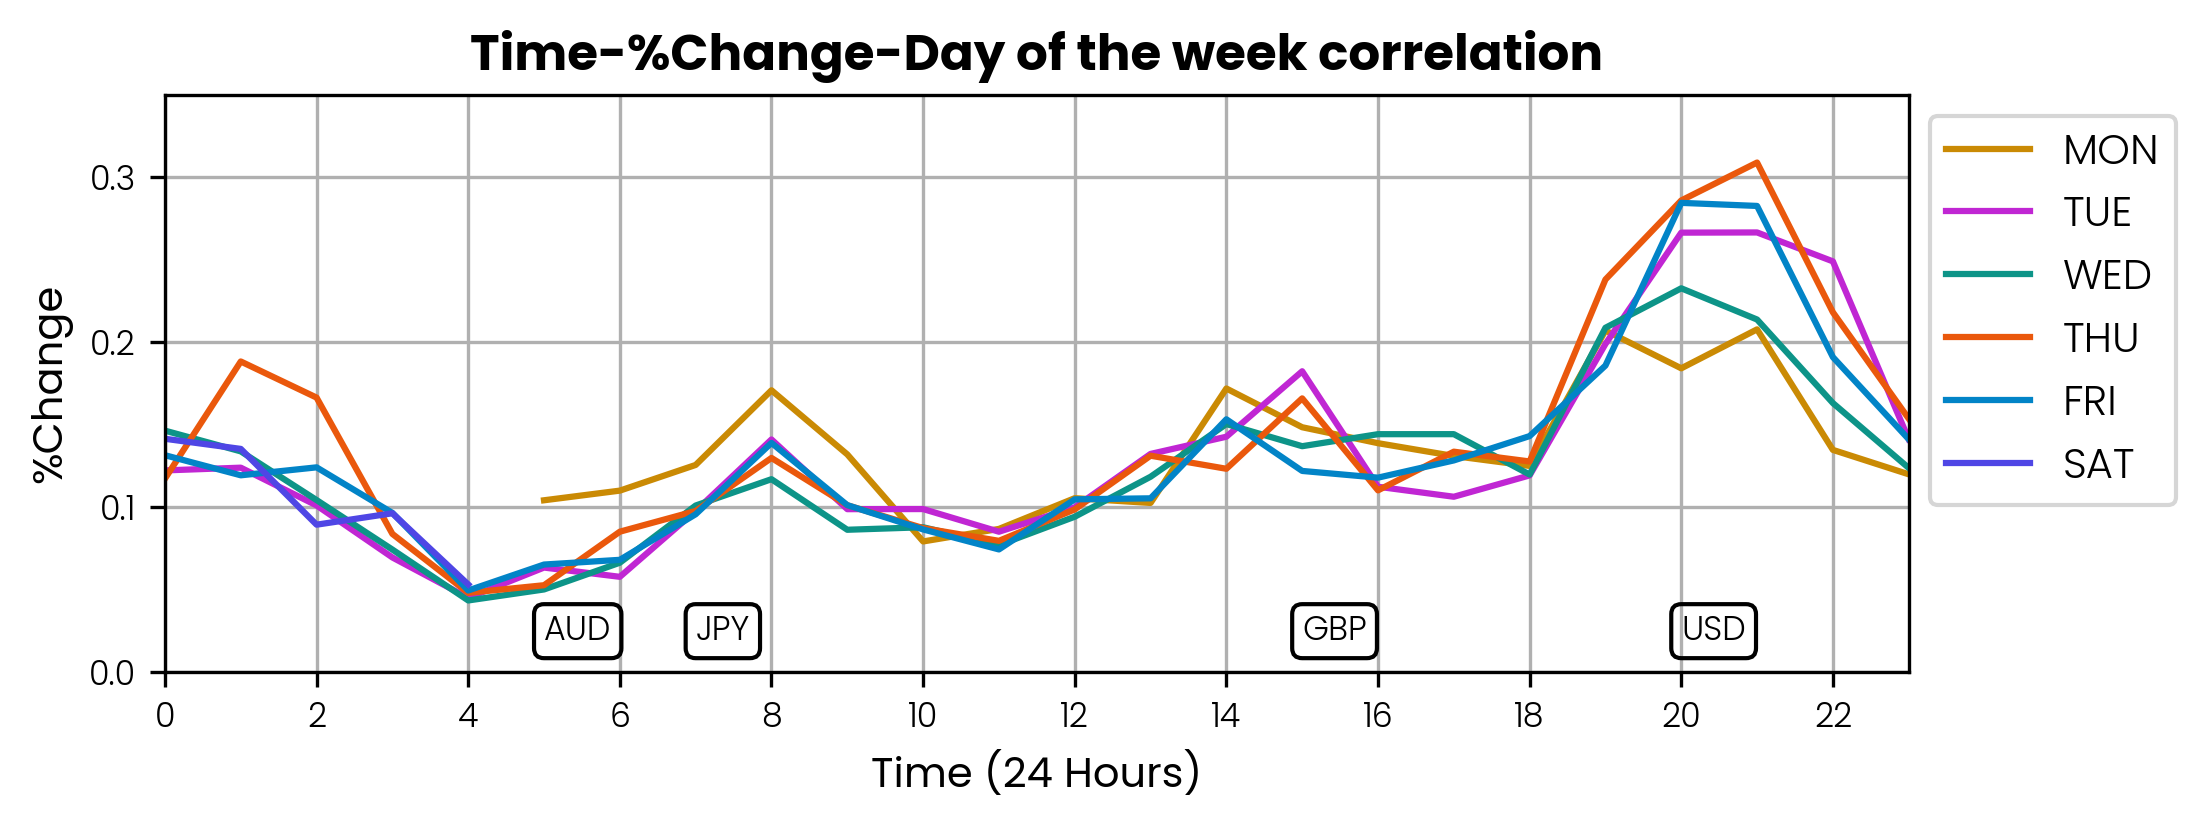

In [49]:
# Plot scatter charts
fig, ax = plt.subplots(1, 1, figsize=(7.5, 2.5))

for column in DF_XAUUSD_A.columns:
    ax.plot(DF_XAUUSD_A.index, 
            DF_XAUUSD_A[column], 
            label=column,
            c=WEEK_PALETTE[column])

for tz in TZ:
    ax.text(TZ[tz][0], 0.02, tz, color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), **C_FONT)

# Format charts
ax.legend(bbox_to_anchor=(1, 1), prop=C_FONT['fontproperties'], fontsize=C_FONT['size'])
plt.xticks(**C_FONT)
plt.yticks(**C_FONT)
ax.set_title('Time-%Change-Day of the week correlation', **H_FONT)
ax.set_xlabel('Time (24 Hours)', **L_FONT)
ax.set_xticks(np.arange(0, 24, 2))
ax.set_xlim([0, 23])
ax.set_ylabel('%Change', **L_FONT)
ax.set_ylim([0, 0.35])
ax.grid(True)

### Scatter: %Change of n candlestick - %Change of n+1 candlestick

In [40]:
# DF_XAUUSD_B = pd.concat([round(DF_XAUUSD.loc[0: DF_XAUUSD.shape[0] - 4, ['%Change']].reset_index(drop=True), 1),
#                          round(DF_XAUUSD.loc[1: DF_XAUUSD.shape[0] - 3, ['%Change']].reset_index(drop=True), 1),
#                          round(DF_XAUUSD.loc[2: DF_XAUUSD.shape[0] - 2, ['%Change']].reset_index(drop=True), 1),
#                          round(DF_XAUUSD.loc[3: DF_XAUUSD.shape[0] - 1, ['%Change']].reset_index(drop=True), 1)],
#                          axis=1)

FRAME = 3
PRECISION = 2

DF_XAUUSD_FRAME = pd.concat([round(DF_XAUUSD.loc[frame: DF_XAUUSD.shape[0] - ((frame * 2) - frame), ['%Change']].reset_index(drop=True), PRECISION)
                         for frame in range(FRAME * 2)],
                         axis=1)

DF_XAUUSD_FRAME.columns = ['i_' + str(frame) for frame in range(FRAME * 2)]

DF_XAUUSD_B = pd.concat([pd.DataFrame({('i_' + str(i + 1) + str(j)): abs(DF_XAUUSD_FRAME.iloc[:, ((i + 1) * j): ((i + 1) * (j + 1))].sum(axis=1))})
                         for (i, j) in zip(sorted([frame for frame in range(FRAME)] * 2), [0, 1] * FRAME)],
                         axis=1)

In [41]:
# Plot scatter charts
fig, ax = plt.subplots(1, 3)

for i in range(3):
    selected_cols = DF_XAUUSD_B.iloc[:, (2 * i): (2 * i) + 2]
    selected_cols = selected_cols.groupby(selected_cols.columns.to_list(), as_index=False).size()
    x, y, s = selected_cols.iloc[:, 0], selected_cols.iloc[:, 1], selected_cols.iloc[:, -1]
    ax[i].scatter(x, y, s=s)
    ax[i].set_title(f'%Change first-last {i + 1} candle', **H_FONT)
    ax[i].set_xlabel(f'%Change of first {i + 1} candle', **L_FONT)
    ax[i].set_ylabel(f'%Change of last {i + 1} candle', **L_FONT)
    ax[i].set_xlim([0, 2])
    ax[i].set_ylim([0, 2])
    ax[i].set_xticks(np.arange(5), np.arange(0, 2.5, 0.5), **C_FONT)
    # ax[i].set_yticks(np.arange(5), np.arange(0, 2.5, 0.5), **C_FONT)
    ax[i].set_aspect(1)

# Format charts
plt.tight_layout()
plt.subplots_adjust(right=1.5)